# Grover's Algorithm
Quantum Search Algorithm for Unstructured Databases


In [5]:
!pip install "qiskit[visualization]" qiskit-aer --quiet

## 1. Overview of Grover's Algorithm
Grover's algorithm은 정렬되지 않은 데이터베이스에서 원하는 항목을 고전적인 방법보다 빠르게 찾을 수 있는 양자 알고리즘입니다.

**핵심 구성요소:**
- Initialization: 모든 상태의 중첩 생성
- Oracle: 원하는 상태에 위상 -1 곱함
- Diffusion Operator: 평균 기준으로 진폭 증폭


## 2. Initialization

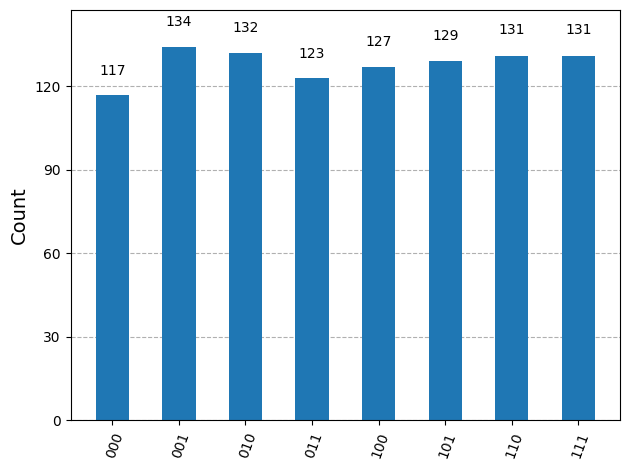

In [33]:
from qiskit import QuantumCircuit, transpile    # 양자 회로 생성, 컴파일
from qiskit_aer import AerSimulator             # 시뮬레이터 백엔드
from qiskit.visualization import plot_histogram # 시각

n = 3                       # 사용할 큐비트 수
qc = QuantumCircuit(n, n)   # 양자 회로 생성

# ① 균등 중첩 생성 ( 큐비트에 hADAMARD 게이트를 적용하여 모든 상태의 균등 중첩 상태로 변환)
qc.h(range(n))
# ② 측정 : 각 큐비트를 대응하는 고전 비트로 측정
qc.measure(range(n), range(n))


backend = AerSimulator()      # 시뮬레이터 백엔드 설정
tqc = transpile(qc, backend)  # 양자 회로를 시뮬레이터에 맞는 형식으로 컴파일
result = backend.run(tqc, shots=1024).result()  # 회로 실행 ( 1024번을 수행하여 확률 분포 측정 )

counts = result.get_counts()  # 각 결과 상태에 대한 측정 횟수
plot_histogram(counts)        # 측정 결과를 히스토그램 형태로 시각화


## 코드 요약 및 해설
- 이 회로는 3개의 큐비트를 모두 Hadamard 게이트를 통해, "모든 가능한 상태의 균등한 중첩 상태"로 만든다.

- 여기서는 n=3이므로, '|000>', '|001>', ..., '|111>' 총 8가지 상태가 동시에 존재하는 중첩 상태가 된다.

- 하지만 이 중첩 상태를 직접 관측할 수는 없고, 측정을 통해서만 정보를 얻을 수 있다.

- 따라서 측정 시에는 중첩된 여러 상태들 중 하나의 상태만 선택되어 고전 비트에 저장된다.

- 이 과정을 여러 번 반복하여 얻은 데이터를 통해 전체 상태들의 관측 확률을 분석할 수 있다.

<br>

## Addition
#### 1. Hadamard 게이트
- Hadamard 게이트는 |0> 상태를 (|0>+|1>)/√2로 바꾼다.
-즉 n개의 큐비트에 적용하면, 2^n개의 상태가 균등하게 중첩된 상태가 된다.
- Grover's 알고리즘에서 모든 가능한 상태를 균등하게 섞은 초기 상태를 만들기 위해 사용된다.

#### 2. 측정이 필요한 이유
- 중첩 상태는 물리적으로 존재하지만, 관측할 수 없다.
- 측정을 하면, 여러 개로 중첩된 상태 중 하나의 상태로 붕괴되고 그 결과가 고전 비트에 저장된다.
- 양자역학에서의 본질적인 특성으로, 측정은 중첩을 하나의 상태로 붕괴시킨다.

#### 3. 실행결과
- 중첩 상태는 확률 진폭으로 구성된 상태이므로, 실행할 때마다 결과 분포가 달라질 수 있다.
- 충분히 많은 샷을 통해 최대한 균등한 분포에 수렴시켜야 한다.

## 3. Oracle (Marking the Solution State)

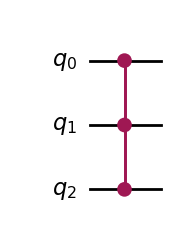

In [31]:
# 오라클 회로 정의 (찾고자 하는 상태에 위상 반전을 주는 회로)
oracle = QuantumCircuit(n)

# CCZ 게이트 적용 (큐비트 0, 1, 2가 모두 1인 상태인 |111>에 -1의 위상을 부여하는 게이트)
oracle.ccz(0, 1, 2)

# 회로 시각화
oracle.draw('mpl')

## 코드 요약 및 해설
- 이 부분은 Grover's 알고리즘의 핵심 요소인 Oracle 회로를 정의하는 부분이다.
- 이 회로는, **찾고자 하는 정답 상태에만 위상을 반전**시켜서 다른 상태들과 구분한다.
- 여기서 'ccz(0, 1, 2)'는 |111> 상태에 -1의 위상을 줘서 위상을 반전시킨다.
- Grover's 알고리즘은 이 상태를 반복적으로 증폭시켜 최종 측정 시 정답 상태가 높은 확률로 관측되도록 유도한다.

<br>

## Addition

#### 1. Oracle이란?
- Grover's 알고리즘에서 찾고자 하는 정답 상태를 표시(mark)하는 연산자가 Oracle이다.
- 정답 상태에만 -1의 위상을 부여하여, 추후 설명될 확산 연산자와 함께 해당 상태의 확률 진폭을 증폭시킨다.

#### 2. CCZ 게이트
- CCZ(Controlled Controlled Z) 게이트는, 세 큐비트가 모두 |1>일 때만 마지막 큐비트에 Z게이트를 적용하여 위상 반전을 일으킨다.
- 여기서 Z 게이트는 |0>과 |1>의 상태는 유지하되, |1> 상태에만 위상 -1을 곱하는 양자 논리 게이트이다.
- 마지막 큐비트에 Z게이트를 적용한다는 것은, 그 큐비트가 |1>인 상태에서만 위상에 -1의 변화를 만들어내는 것과 같다. 이는 특정 상태에만 위상 반전을 유도하는데 사용된다.

#### 3. 정답 상태가 |111>이 아니라면?
- CCZ 게이트는 오직 |111>일 때만 위상 -1을 적용하므로, 정답 상태가 |111>이 아닐 경우 직접 적용할 수가 없다.
- 이런 경우 X게이트를 활용하여 원하는 정답 상태를 |111>처럼 보이도록 변환하는 작업이 필요하다.
- 예를 들어, 정답 상태가 |101>인 경우, 큐비트1에 X게이트를 적용하여 |101> -> |111>로 만든 후 CCZ를 적용하고 다시 X게이트를 적용해 원래 상태로 복원해야 한다.
- 여기서 X 게이트는 |0>과 |1>을 서로 뒤바꾸는 양자 논리 게이트이다.


## 4. Diffusion Operator (Inversion About the Mean)

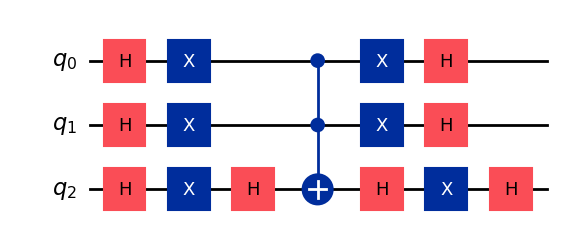

In [36]:
def diffusion_operator(n):
    qc = QuantumCircuit(n) # 양자 회로 생성

    # ① 모든 큐비트에 Hadamard 게이트 적용
    qc.h(range(n))
    # ② 모든 큐비트에 X 게이트 적용
    qc.x(range(n))
    # ③ 마지막 큐비트에 H 게이트 적용
    qc.h(n-1)
    # ④ 다중 제어 X 게이트 (앞 뒤의 H 게이트와 연결되어, 결과적으로 다중 제어 Z 게이트 효)
    qc.mcx(list(range(n-1)), n-1)
    # ⑤ 마지막 큐비트에 다시 H 게이트 적용 (H - X - H = Z 구조 마무리)
    qc.h(n-1)
    # ⑥ 모든 큐비트에 X 게이트 다시 적용
    qc.x(range(n))
    # ⑦ 모든 큐비트에 Hadamard 게이트 다시 적용
    qc.h(range(n))

    return qc

diff_op = diffusion_operator(n)
diff_op.draw('mpl')

## 코드 요약 및 해설
- 이 함수는 Grover's 알고리즘에서 정답 상태의 진폭을 증폭시키는 **확산 연산자**를 구현한 부분이다.
- 이 연산자는 **전체 상태들의 진폭을 평균에 대해 대칭 반사**하여, Oracle로 위상이 반전된 정답 상태의 진폭을 증폭시키는 역할을 한다.
- 정답 상태의 진폭은 점점 커지고, 다른 상태들은 작아지면서 최종 측정에서 정답 상태가 더 자주 선택되도록 한다.

## Addition

#### 1. 각 게이트 정리
- X 게이트 : |0>을 |1>로, |1>을 |0>으로 바꾸는 양자 NOT 게이트
- Z 게이트 : |0>은 그대로 두고, |1> 상태에만 위상 -1을 곱하는 게이트
- H 게이트 : |0> 또는 |1>을 균등한 중첩 상태로 바꾸는 게이트

#### 2. H-X-H = Z 변환
- 코드 상 mcx()는 다중 제어 X 게이트이지만, **타깃 큐비트에 Hadamard → mcx → Hadamard**를 적용하면 다중 제어 Z와 동일하게 작동한다.
- 이때 위상 -1이 부여되는 대상은, 앞서 모든 큐비트에 X 게이트를 적용해 **평균점이 되도록 옮겨둔 |000⟩ 상태**이다.

#### 3. mcx 게이트의 조건
- `qc.mcx(list(range(n-1)), n-1)`은 n-1개의 큐비트가 모두 |1⟩일 때만 마지막 큐비트에 X 게이트를 적용한다.
- **Hadamard–mcx–Hadamard** 조합은 평균점(|000⟩)에 위상 -1을 넣어 주어, 확산 연산자의 “평균에 대한 대칭 반사” 행렬을 완성한다.

#### 4. Diffusion Operator ― 단계별 설명

1. **좌표계 회전으로 평균점을 원점으로 가져오기**  
   모든 큐비트에 Hadamard 게이트를 건다.  
   이렇게 축을 돌리면, ‘모든 상태가 똑같이 섞인 균등중첩’이 새 좌표계의 원점 `000` 자리에 자리 잡는다.

2. **원점을 `111` 자리로 뒤집기**  
   모든 큐비트에 X 게이트를 건다.  
   다중 제어 X(mcx)는 제어 비트가 모두 1일 때만 반응하므로, 원점을 `111` 위치로 옮겨 mcx가 정확히 그 지점을 잡을 수 있게 만든다.

3. **그 지점에 위상 −1을 심어 ‘거울’을 설치**  
   마지막 큐비트에 Hadamard → mcx → Hadamard 순서를 적용한다.  
   Hadamard–X–Hadamard 조합은 mcx를 다중 제어 Z처럼 바꿔 주기 때문에, 방금 옮겨 둔 `111` 한 점에만 위상 −1이 들어가 평균점 기준의 거울이 완성된다.

4. **좌표축과 비트값을 원래대로 복귀**  
   두 번째 단계에서 썼던 X 게이트를 다시 한 번 전 큐비트에 걸어 원점을 `111` → `000`으로 되돌리고,  
   Hadamard를 다시 한 번 전 큐비트에 걸어 좌표축도 원래 계산-기저로 되돌린다.

---

#### 최종 효과
* 회로상의 좌표계는 처음 상태로 돌아왔지만, 진폭은 방금 만든 거울에 의해 **평균에 대해 반사된** 채로 남는다.  
* Oracle이 위상 −1로 ‘눌러’ 두었던 정답 상태는 평균에서 가장 멀어져 진폭이 커지고, 다른 상태들은 조금씩 줄어든다.  
* 이 Oracle → Diffusion 세트를 여러 번 반복하면 **정답 상태가 측정될 확률이 급격히 높아진다**.


## 5. Full Grover Circuit and Simulation

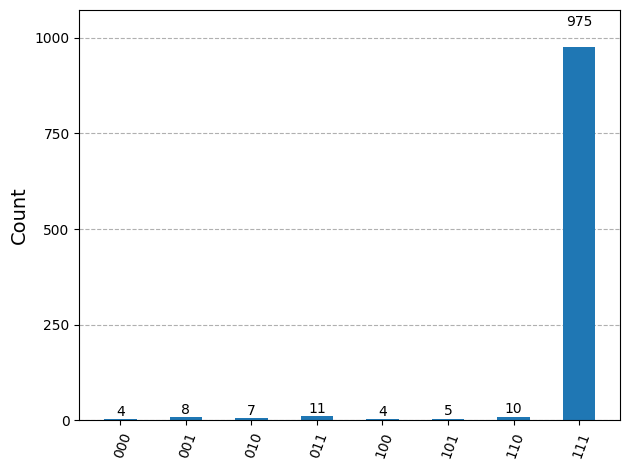

In [37]:
import numpy as np

grover = QuantumCircuit(n, n) # n개의 큐비트와 n개의 클래식 비트를 가지는 회로 생성

# ① 모든 큐비트를 균등중첩 상태로 만듦
grover.h(range(n))

# ② Grover 반복 횟수 계산( 정답 상태를 가장 잘 증폭시킬 수 있는 최적 반복 수 )
k = int(np.floor(np.pi/4 * np.sqrt(2**n)))

# ③ Grover iteration( Oracle과 Diffusion을 반복 수행하여 정답 상태의 진폭을 증폭 )
for _ in range(k):
    grover.compose(oracle, inplace=True) # 오라클: 정답 상태에만 위상 -1 부여
    grover.compose(diffusion_operator(n), inplace=True) # 확산: 평균 진폭 기준으로 반사 → 정답 상태 진폭 증폭

# ④ 모든 큐비트를 대응하는 고전 비트에 측정하여 결과를 얻음
grover.measure(range(n), range(n))

# ⑤ Aer's 시뮬레이터에서 회로를 컴파일하고 1024번 실행
backend = AerSimulator()
tgrover = transpile(grover, backend)
result = backend.run(tgrover, shots=1024).result()

# ⑥ 측정 결과를 히스토그램으로 시각
counts = result.get_counts()
plot_histogram(counts)


## 6. 결과 해석
- 가장 높은 확률로 측정된 상태는 Oracle에서 지정한 해답 상태이다.
- 초기에는 모든 상태가 균등하게 중첩되어 있기 때문에 각 상태가 측정될 확률이 거의 동일하다. 그러나 Oracle이 정답 상태의 위상을 -1로 반전시키고, Diffusion Operator가 그 상태의 진폭을 점점 증폭시키는 과정을 반복하면서 **정답 상태의 진폭이 커지고, 결국 측정 시 높은 확률로 그 상태가 관측된다.**
- Grover 알고리즘은 고전적인 O(N) 탐색보다 빠른  **O(√N)**의 속도로 정답 상태를 찾을 수 있다.
- 결과적으로, 위 코드를 통해 **정답 상태가 전체 측정 결과 중 가장 빈도 높게 등장**하는 것을 확인할 수 있다.
